In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 3


In [2]:
import tensorflow as tf
import numpy as np
from numpy.linalg import inv
import os.path as osp

from tflearn.layers.core import fully_connected
from tflearn.layers.conv import conv_2d

from geo_tool import Point_Cloud

from general_tools.notebook.tf import reset_tf_graph
from general_tools.clustering.convenience import find_nearest_neighbors
from general_tools.in_out import create_dir

from tf_lab.point_clouds.encoders_decoders import decoder_with_fc_only
from tf_lab.external.structural_pc_losses import losses
from tf_lab.data_sets.numpy_dataset import NumpyDataset
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.in_out import PointCloudDataSet
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params
from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.diff_maps import helper
from tf_lab.diff_maps.basic_nets import pc_net, diff_mlp_net, diff_conv_net, pc_versions, Basic_Net
from tf_lab.diff_maps.in_out import raw_data, produce_net_data, prep_splits_labels_for_task, \
                                    produce_diff_maps, classes_of_tasks

In [3]:
%matplotlib inline

In [4]:
top_mesh_dir = '/orions4-zfs/projects/optas/DATA/Meshes/SCAPE_8_poses/'
top_data_dir = '/orions4-zfs/projects/optas/DATA/OUT/latent_diff_maps/experiments/SCAPE_8_poses'
top_out_dir = '/orions4-zfs/projects/optas/DATA/OUT/latent_diff_maps/experiments/SCAPE_8_poses/reconstructions'

gt_param_f = osp.join(top_mesh_dir, 'gt_shape_params.mat')
create_dir(top_out_dir);
n_pose_classes = helper.n_pose_classes

In [5]:
def diff_reconstructor(n_cons, n_pc_points):
    'Optimized for n_cons = 40'
    with tf.variable_scope('conv_based_reconstructor'):
        feed_pl = tf.placeholder(tf.float32, shape=(None, n_cons, n_cons))
        labels_pl = tf.placeholder(tf.float32, shape=(None, n_pc_points, 3))
        layer = tf.expand_dims(feed_pl, -1)
        layer = conv_2d(layer, nb_filter=20, filter_size=3, strides=2, activation='relu')
        layer = conv_2d(layer, nb_filter=20, filter_size=6, strides=2, activation='relu')
        net_out = decoder_with_fc_only(layer, layer_sizes=[128, 128, n_pc_points * 3], b_norm=False)
        net_out = tf.reshape(net_out, [-1, n_pc_points, 3])
    return net_out, feed_pl, labels_pl

In [6]:
use_pc = True

sub_member_per_class = 50
n_shapes = sub_member_per_class * n_pose_classes
val_per = 0.10
test_per = 0.15
train_per = 1.0 - (val_per + test_per)
n_pc_points = 4096
seed = 42

use_loss = 'chamfer'

knn = 0
arch = 'conv'
mean_norm_diffs = True
n_cons = 40

synced_bases_file = osp.join(top_data_dir, '50_extract_%d_knn_50_fmapd.mat' % (knn,) )

In [7]:
gt_latent_params, in_pcs, pose_labels = \
raw_data(top_mesh_dir, gt_param_f, sub_member_per_class, n_pc_points)
diff_maps = produce_diff_maps(synced_bases_file, n_cons, n_shapes)

np.random.seed(seed)
r_perm = np.random.permutation(np.arange(n_shapes))
in_pcs = in_pcs[r_perm]
diff_maps = diff_maps[r_perm]

In [8]:
net_data = dict()
batch_size = 50

if use_pc:    
    net_data['train'] = PointCloudDataSet(in_pcs[:300])
    net_data['test'] = PointCloudDataSet(in_pcs[300:360])
    net_data['val'] = PointCloudDataSet(in_pcs[350:]) # not a bug
    analogies_feed = in_pcs[300:]
else:    
    net_data['train'] = NumpyDataset([diff_maps[:300], in_pcs[:300]])
    net_data['test'] = NumpyDataset([diff_maps[300:360], in_pcs[300:360]])
    net_data['val'] = NumpyDataset([diff_maps[360:], in_pcs[360:]])    
    learning_rate = 0.005
    max_epochs = 850
    analogies_feed = diff_maps[300:]

analogies_pcs = in_pcs[300:]
all_train_pcs = in_pcs[:300]
all_train_maps = diff_maps[:300]

In [10]:
if not use_pc:
    reset_tf_graph()
    tf.set_random_seed(seed)
    nn_distance, approx_match, match_cost = losses()
    x_reconstr, feed_pl, labels_pl = diff_reconstructor(n_cons, n_pc_points)

    if use_loss == 'chamfer':
        cost_p1_p2, _, cost_p2_p1, _ = nn_distance(x_reconstr, labels_pl)
        loss = tf.reduce_mean(cost_p1_p2) + tf.reduce_mean(cost_p2_p1)
    elif use_loss == 'emd':
        match = approx_match(x_reconstr, labels_pl)
        loss = tf.reduce_mean(match_cost(x_reconstr, labels_pl, match))

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_step = optimizer.minimize(loss)

    g = tf.get_default_graph()
    latent_coder = g.get_tensor_by_name('conv_based_reconstructor/Relu:0') # Use embedding to do analogies.

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    init = tf.global_variables_initializer()

    sess = tf.Session(config=config)
    sess.run(init)

In [11]:
if not use_pc:
    batches_for_epoch = net_data['train'].n_examples / batch_size
    n_plot = 20
    for epoch in xrange(max_epochs):
        epoch_loss = 0.0
        for _ in xrange(batches_for_epoch):
            feed, gt = net_data['train'].next_batch(batch_size)
            feed_dict = {feed_pl:feed, labels_pl:gt}
            _, l = sess.run([train_step, loss], feed_dict)
            epoch_loss += l
        if epoch % n_plot == 0:        
            print epoch, epoch_loss / float(batches_for_epoch),

            feed, gt = net_data['val'].next_batch(net_data['val'].n_examples)
            feed_dict = {feed_pl:feed, labels_pl:gt}
            l = sess.run(loss, feed_dict)
            print l

In [25]:
if use_pc:    
    reset_tf_graph()
    tf.set_random_seed(seed)
    train_params = default_train_params()
    bneck = 32
    train_dir = osp.join(top_data_dir, 'temp')
    create_dir(train_dir)    
    encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck)
    
    dec_args['verbose'] = False
    enc_args['verbose'] = False
    
    conf = Conf(n_input = [n_pc_points, 3],
                loss = use_loss,
                training_epochs = 400,
                batch_size = train_params['batch_size'],
                denoising = False,
                learning_rate = train_params['learning_rate'],
                train_dir = train_dir,
                loss_display_step = 20,
                saver_step = None,
                z_rotate = False,
                encoder = encoder,
                decoder = decoder,
                encoder_args = enc_args,
                decoder_args = dec_args
               )
    conf.experiment_name = 'test'
    conf.held_out_step = 20
    conf.save(osp.join(train_dir, 'configuration'))
    ae = PointNetAutoEncoder(conf.experiment_name, conf)    
    ae.train(net_data['train'], conf, held_out_data=net_data['val'])

('Epoch:', '0020', 'training time (minutes)=', '0.0129', 'loss=', '0.001167129')
('Held Out Data :', 'forward time (minutes)=', '0.0007', 'loss=', '0.001146776')
('Epoch:', '0040', 'training time (minutes)=', '0.0127', 'loss=', '0.000841507')
('Held Out Data :', 'forward time (minutes)=', '0.0004', 'loss=', '0.000863171')
('Epoch:', '0060', 'training time (minutes)=', '0.0129', 'loss=', '0.000775220')
('Held Out Data :', 'forward time (minutes)=', '0.0004', 'loss=', '0.000789023')
('Epoch:', '0080', 'training time (minutes)=', '0.0131', 'loss=', '0.000648322')
('Held Out Data :', 'forward time (minutes)=', '0.0005', 'loss=', '0.000668559')
('Epoch:', '0100', 'training time (minutes)=', '0.0130', 'loss=', '0.000598826')
('Held Out Data :', 'forward time (minutes)=', '0.0004', 'loss=', '0.000632949')
('Epoch:', '0120', 'training time (minutes)=', '0.0128', 'loss=', '0.000573527')
('Held Out Data :', 'forward time (minutes)=', '0.0004', 'loss=', '0.000576763')
('Epoch:', '0140', 'training

In [21]:
for i in range(len(pc_analogies)):
    print i
    Point_Cloud(analogies_pcs[i]).plot(in_u_sphere=False, azim=-45);

In [72]:
analogy_1 = [7, 94, 30]
analogy_2 = [7, 2, 30]
analogy_3 = [74, 44, 56]

In [76]:
A, B, C = analogy_3

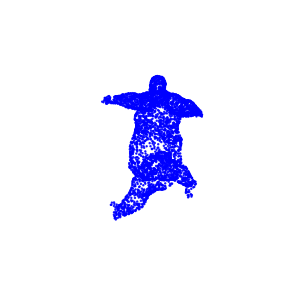

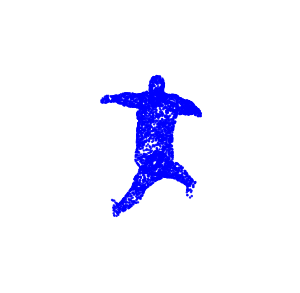

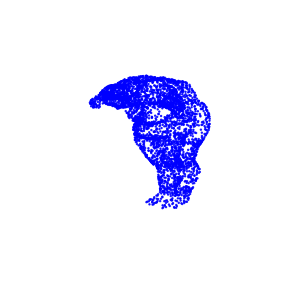

In [77]:
Point_Cloud(analogies_pcs[A]).plot(in_u_sphere=False, azim=-45, show_axis=False);
Point_Cloud(analogies_pcs[B]).plot(in_u_sphere=False, azim=-45, show_axis=False);
Point_Cloud(analogies_pcs[C]).plot(in_u_sphere=False, azim=-45, show_axis=False);

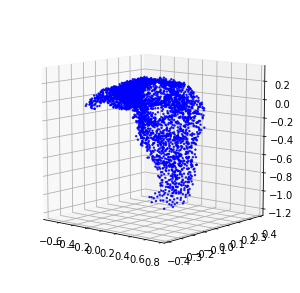

In [78]:
# FOR PC-NET
la, lb, lc = ae.transform(analogies_feed[[A, B, C]])
query = (lc + lb - la).reshape(1, ae.bottleneck_size)
d_via_net = ae.decode(query)[0]
Point_Cloud(d_via_net).plot(in_u_sphere=False, azim=-50)

tag = 'analogy_3'
out_dir = create_dir(osp.join(top_out_dir, tag, 'pc_ae'))
np.savetxt(osp.join(out_dir, 'd' + '.txt'), d_via_net)

In [85]:
ra, rb, rc = sess.run(ae.x_reconstr, feed_dict={feed_pl:analogies_feed[[A, B, C]]})

# if use_pc

# else:
#     D = analogies_maps[B].dot(inv(analogies_maps[A])).dot(analogies_maps[C])
#     D = np.expand_dims(D, 0)

# rd = sess.run(x_reconstr, feed_dict = {feed_pl:D})[0]

ValueError: Cannot feed value of shape (3, 4096, 3) for Tensor u'conv_based_reconstructor/Placeholder:0', which has shape '(?, 40, 40)'

In [29]:
Point_Cloud(ra).plot(in_u_sphere=False, azim=-45, show_axis=False);
Point_Cloud(rb).plot(in_u_sphere=False, azim=-45, show_axis=False);
Point_Cloud(rc).plot(in_u_sphere=False, azim=-45, show_axis=False);
Point_Cloud(rd).plot(in_u_sphere=False, azim=-45, show_axis=False);

NameError: name 'ra' is not defined

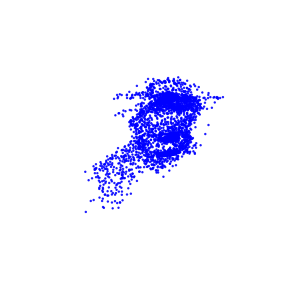

In [34]:
use_recon = True  # Alternatively, do knn query.

la, lb, lc = sess.run(latent_coder, feed_dict={feed_pl:analogies_feed[[A, B, C]]})
query = (lc + lb - la).reshape(1, 128)
feed_dict = {latent_coder: query}

if use_recon:
    d_via_net = sess.run(x_reconstr, feed_dict=feed_dict)[0]
else:
    all_latent_train  = sess.run(latent_coder, feed_dict={feed_pl:all_train_maps})
    nn0 = find_nearest_neighbors(query, all_latent_train, 1)[0][0][0]
    d_via_net = all_train_pcs[nn0]

Point_Cloud(d_via_net).plot(in_u_sphere=False, azim=0, show_axis=False);

In [95]:
# SAVE selected analogies.
tag = 'analogy_?'
out_dir = create_dir(osp.join(top_out_dir, tag, 'gt'))
for name, pc in zip (['a', 'b', 'c', 'd'], [analogies_pcs[A], analogies_pcs[B], analogies_pcs[C], d_via_net]):
    np.savetxt(osp.join(out_dir, name + '.txt'), pc)
    
out_dir = create_dir(osp.join(top_out_dir, tag, 'recon'))
for name, pc in zip (['a', 'b', 'c', 'd'], [ra, rb, rc, rd]):
    np.savetxt(osp.join(out_dir, name + '.txt'), pc)

In [45]:
# ls /orions4-zfs/projects/optas/DATA/OUT/latent_diff_maps/experiments/SCAPE_8_poses/reconstructions

In [ ]:
tag = 'analogies_for_siggraph/analogy_3'
out_dir = create_dir(osp.join(top_out_dir, tag, 'gt'))
saved_pcs = []
for name in ['a', 'b', 'c', 'd']:
    saved_pcs.append(np.loadtxt(osp.join(out_dir, name + '.txt')))

np.all(analogies_pcs[A] == saved_pcs[0]) \
and np.all(analogies_pcs[B] == saved_pcs[1]) \
and np.all(analogies_pcs[C] == saved_pcs[2])

for p in saved_pcs:
    Point_Cloud(p).plot(in_u_sphere=False, azim=-45)